In [1]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape, Conv2D, Conv2DTranspose, Lambda, BatchNormalization
#from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
import numpy as np
import msprime
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import umap
from tempfile import TemporaryFile

In [2]:
# To sort the genotype matrices

from sklearn.neighbors import NearestNeighbors
def sort_min_diff(amat):
    '''this function takes in a SNP matrix with indv on rows and returns the same 
    matrix with indvs sorted by genetic similarity.this problem is NP, so here we 
    use a nearest neighbors approx.  it's not perfect, but it's fast and generally performs ok.
    assumes your input matrix is a numpy array'''
    mb = NearestNeighbors(len(amat), metric='manhattan').fit(amat)
    v = mb.kneighbors(amat)
    smallest = np.argmin(v[0].sum(axis=1))
    return amat[v[1][smallest]]

In [3]:
# Simulates the genotype matrices

def simulations(range_=10000, img_dim=64):
    
    gene_list = []
    resized_img = []
    rr_min, rr_max = 1e-7, 1e-9
    rr = np.random.uniform(rr_min, rr_max, size=range_)
    
    for i in range(range_):
        i = msprime.simulate(sample_size=100, Ne=10000, length=1e5, mutation_rate=1e-8, recombination_rate=rr[i])
        gene_list.append(np.array(i.genotype_matrix(), dtype=float))
    
    for i in gene_list:
        resized_img.append(resize(sort_min_diff(sort_min_diff(i.T).T).T, (img_dim, img_dim), preserve_range=True))
    
    return np.asarray(resized_img), rr, rr_min, rr_max

In [4]:
# Call's the simulation function

img_data, rr, rr_min, rr_max = simulations(range_=10000, img_dim=32)

In [5]:
# To split the data into train, test and validation data

def data_split(data, rec_rate):
    
    x_train = data[:int(len(data) * 0.7)]
    x_test = data[int(len(data) * 0.7):int(len(data) * 0.85)]
    x_val = data[int(len(data) * 0.85):]
    
    # Corresponding to x_test data
    rr_test = rec_rate[int(len(rec_rate) * 0.7):int(len(rec_rate) * 0.85)]
    
    return x_train, x_test, x_val, rr_test

In [6]:
# Call's the data_split function

x_train, x_test, x_val, rr_test = data_split(img_data, rr)

In [7]:
# Flattening of the images

x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))
x_val = x_val.reshape(len(x_val), np.prod(x_val.shape[1:]))

In [8]:
# Parameters

img_size = 32
original_dim = img_size * img_size
latent_dim = 300

In [9]:
inp_dim = x_train.shape[1]
hidden_dim = 300

autoencoder = Sequential()
# Encoder Layers
autoencoder.add(Dense(3 * hidden_dim, input_shape=(inp_dim,), activation='relu'))
autoencoder.add(Dense(2 * hidden_dim, activation='relu'))
autoencoder.add(Dense(hidden_dim, activation='relu'))

# Decoder Layers
autoencoder.add(Dense(2 * hidden_dim, activation='relu'))
autoencoder.add(Dense(3 * hidden_dim, activation='relu'))
autoencoder.add(Dense(inp_dim, activation='sigmoid'))

In [10]:
input_img = Input(shape=(inp_dim,))
encoder_layer1 = autoencoder.layers[0]
encoder_layer2 = autoencoder.layers[1]
encoder_layer3 = autoencoder.layers[2]
encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))

In [11]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
his = autoencoder.fit(x_train, x_train, epochs=100, batch_size=128, validation_data=(x_val, x_val))

Train on 7000 samples, validate on 1500 samples
Epoch 1/100
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.3427 - accuracy: 0.0465 - val_loss: 0.3131 - val_accuracy: 0.0474
Epoch 2/100
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.3121 - accuracy: 0.0472 - val_loss: 0.3113 - val_accuracy: 0.0474
Epoch 3/100
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.3101 - accuracy: 0.0472 - val_loss: 0.3099 - val_accuracy: 0.0475
Epoch 4/100
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.3090 - accuracy: 0.0472 - val_loss: 0.3088 - val_accuracy: 0.0475
Epoch 5/100
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.3083 - accuracy: 0.0472 - val_loss: 0.3092 - val_accuracy: 0.0475
Epoch 6/100
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.3079 - accuracy: 0.0472 - val_loss: 0.3081 - val_accuracy: 0.0475
Epoch 7/100
7000/7000 [==============================] - 9s 1ms/samp

7000/7000 [==============================] - 9s 1ms/sample - loss: 0.2998 - accuracy: 0.0473 - val_loss: 0.3017 - val_accuracy: 0.0475
Epoch 57/100
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.2997 - accuracy: 0.0473 - val_loss: 0.3018 - val_accuracy: 0.0475
Epoch 58/100
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.2997 - accuracy: 0.0473 - val_loss: 0.3017 - val_accuracy: 0.0475
Epoch 59/100
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.2996 - accuracy: 0.0473 - val_loss: 0.3018 - val_accuracy: 0.0475
Epoch 60/100
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.2996 - accuracy: 0.0473 - val_loss: 0.3016 - val_accuracy: 0.0475
Epoch 61/100
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.2995 - accuracy: 0.0473 - val_loss: 0.3015 - val_accuracy: 0.0475
Epoch 62/100
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.2994 - accuracy: 0.0473 - val_loss: 0.3015 

In [13]:
def plot_loss(loss, val_loss, accuracy, val_accuracy):
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    
    plt.subplot(122)
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()

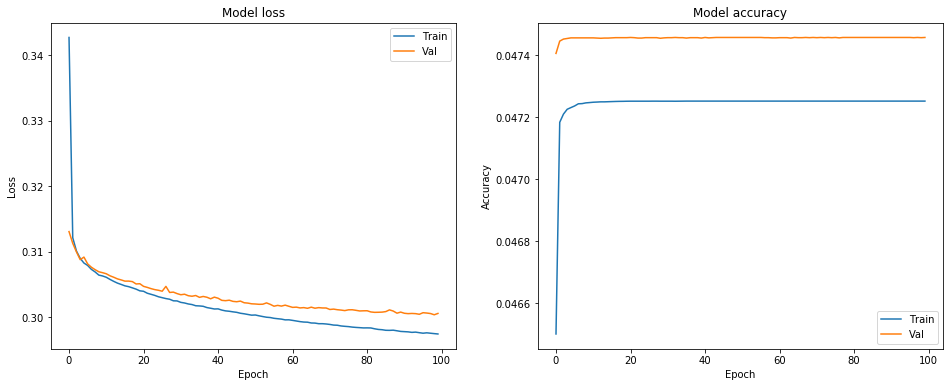

In [14]:
plot_loss(his.history['loss'], his.history['val_loss'], his.history['accuracy'], his.history['val_accuracy'])

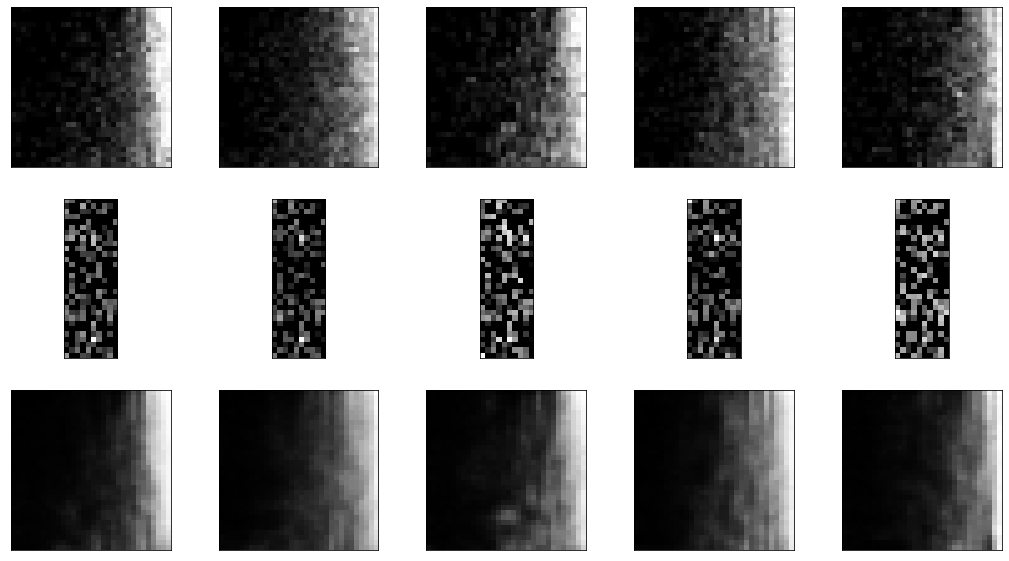

In [15]:
num_images = 5
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 10))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(30, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
tsne = TSNE(n_components=2, random_state=0)
x_tsne = tsne.fit_transform(encoded_imgs)

In [17]:
reducer = umap.UMAP()
umap_ = reducer.fit_transform(encoded_imgs)

In [18]:
low = np.argmin(rr)

In [19]:
high = np.argmax(rr)

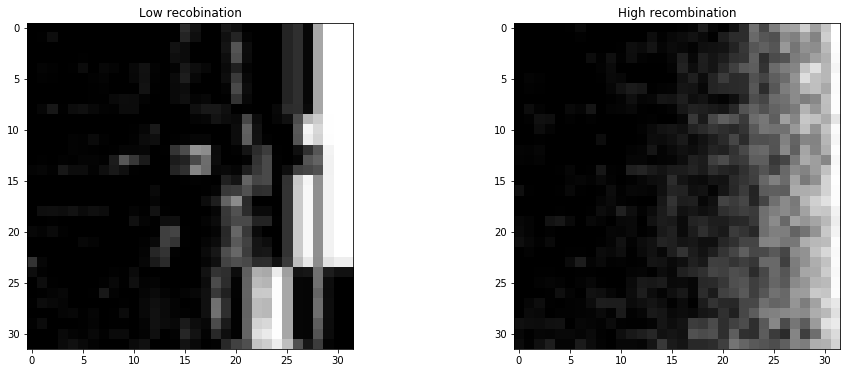

In [20]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title('Low recobination')
plt.imshow(img_data[low])

plt.subplot(122)
plt.title('High recombination')
plt.imshow(img_data[high])
plt.show()

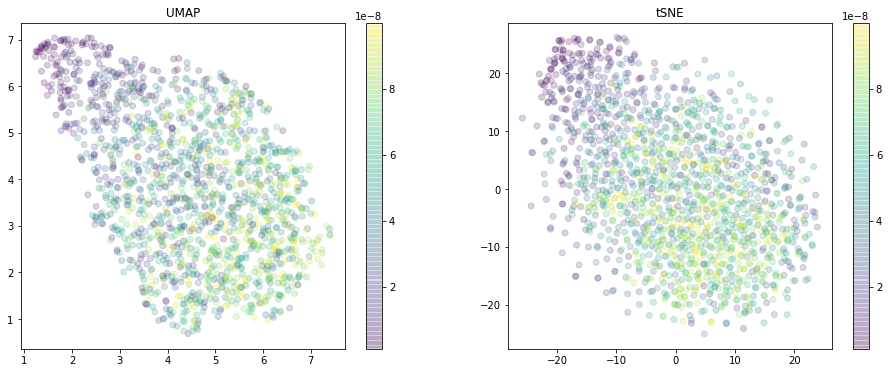

In [21]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.scatter(umap_[:,0], umap_[:,1], alpha=0.2, c=rr_test, cmap='viridis')
plt.title('UMAP')
plt.colorbar()

plt.subplot(122)
plt.scatter(x_tsne[:,0], x_tsne[:,1], alpha=0.2, c=rr_test, cmap='viridis')
plt.title('tSNE')
plt.colorbar()
plt.show()

In [22]:
x_train.shape

(7000, 1024)